Here’s how we can adapt the fuzzy inference system (FIS) for an Amazon delivery system scenario, where the goal is to rate an Amazon order based on three factors:

	1.	Quality of goods received
	2.	Delivery time taken
	3.	Damage to delivered goods

The consequent will be the rating on Amazon. We’ll use fuzzy logic to map these inputs to an Amazon rating, which will be a score between 1 and 5 stars.

## 1. Defining the Problem

We have three input antecedents:

	•	Quality of goods received: This can be rated on a scale from 0 (very poor quality) to 10 (excellent quality).
	•	Delivery time taken: This measures how late or early the delivery was, on a scale from 0 (very late) to 10 (delivered early).
	•	Damage to delivered goods: This ranges from 0 (no damage) to 10 (severe damage).

The output consequent will be the Amazon rating: A score between 1 and 5 stars.


## 2. Implementing the Fuzzy Inference System (FIS)

#### 2.1. Define Fuzzy Variables and Membership Functions

We need to define the membership functions for our inputs (quality, delivery time, damage) and output (Amazon rating).

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Input fuzzy variables
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
delivery_time = ctrl.Antecedent(np.arange(0, 11, 1), 'delivery_time')
damage = ctrl.Antecedent(np.arange(0, 11, 1), 'damage')

# Output fuzzy variable
rating = ctrl.Consequent(np.arange(1, 6, 1), 'rating')

# Membership functions for quality
quality['poor'] = fuzz.trimf(quality.universe, [0, 0, 5])
quality['average'] = fuzz.trimf(quality.universe, [0, 5, 10])
quality['excellent'] = fuzz.trimf(quality.universe, [5, 10, 10])

# Membership functions for delivery time
delivery_time['late'] = fuzz.trimf(delivery_time.universe, [0, 0, 5])
delivery_time['on_time'] = fuzz.trimf(delivery_time.universe, [0, 5, 10])
delivery_time['early'] = fuzz.trimf(delivery_time.universe, [5, 10, 10])

# Membership functions for damage
damage['no_damage'] = fuzz.trimf(damage.universe, [0, 0, 5])
damage['minor_damage'] = fuzz.trimf(damage.universe, [0, 5, 10])
damage['severe_damage'] = fuzz.trimf(damage.universe, [5, 10, 10])

# Membership functions for rating
rating['very_bad'] = fuzz.trimf(rating.universe, [1, 1, 2])
rating['bad'] = fuzz.trimf(rating.universe, [1, 2, 3])
rating['okay'] = fuzz.trimf(rating.universe, [2, 3, 4])
rating['good'] = fuzz.trimf(rating.universe, [3, 4, 5])
rating['excellent'] = fuzz.trimf(rating.universe, [4, 5, 5])

#### 2.2. Define Fuzzy Rules

Now, we define rules for how these inputs should affect the output rating. For example:

	•	If quality is excellent and delivery time is early and damage is no_damage, then the rating is excellent.
	•	If quality is poor or damage is severe_damage, then the rating is very_bad.

In [2]:
rule1 = ctrl.Rule(quality['excellent'] & delivery_time['early'] & damage['no_damage'], rating['excellent'])
rule2 = ctrl.Rule(quality['average'] & delivery_time['on_time'] & damage['minor_damage'], rating['good'])
rule3 = ctrl.Rule(quality['poor'] | damage['severe_damage'], rating['very_bad'])
rule4 = ctrl.Rule(delivery_time['late'] & damage['minor_damage'], rating['bad'])
rule5 = ctrl.Rule(quality['average'] & delivery_time['late'], rating['okay'])

#### 2.3. Create and Simulate the Fuzzy Inference System

Next, we create a control system using the rules and simulate it with a sample input (e.g., quality = 7, delivery time = 5, and damage = 2).

Amazon Rating: 4.00


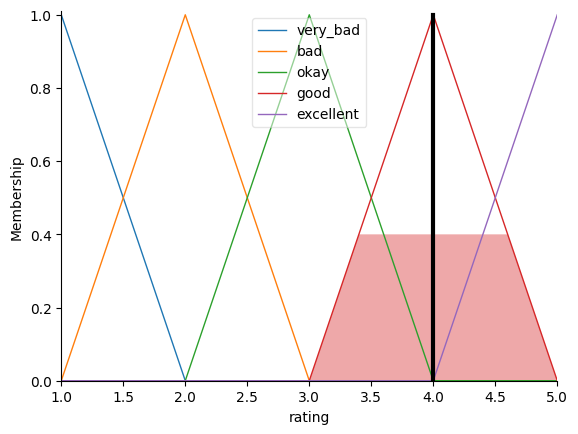

In [4]:
# Create the control system
rating_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
rating_sim = ctrl.ControlSystemSimulation(rating_ctrl)

# Provide input values for the simulation
rating_sim.input['quality'] = 7  # Quality of goods received
rating_sim.input['delivery_time'] = 5  # Delivery time taken
rating_sim.input['damage'] = 2  # Damage to delivered goods

# Compute the output (Amazon rating)
rating_sim.compute()
print(f"Amazon Rating: {rating_sim.output['rating']:.2f}")

# Visualize the result
rating.view(sim=rating_sim)

## 3. Fuzzy c-means clustering

We’ll use Fuzzy C-Means (FCM) clustering to group delivery scenarios into different categories, such as:

	•	Fast and reliable
	•	Late but good quality
	•	Damaged and poor service

#### 3.1. Preparing the Dataset

We’ll generate random delivery data for clustering. The data will include values for:

	•	Quality of goods received (from 0 to 10)
	•	Delivery time taken (from 0 to 10, where 0 is late, and 10 is early)
	•	Damage to delivered goods (from 0 to 10, where 0 is no damage, and 10 is severe damage)

##### 3.1.1. Generating Sample Data for Deliveries


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate delivery data: quality, delivery_time, and damage
np.random.seed(42)
quality = np.random.uniform(0, 10, 100)  # Quality of goods received (0-10)
delivery_time = np.random.uniform(0, 10, 100)  # Delivery time taken (0-10)
damage = np.random.uniform(0, 10, 100)  # Damage to goods (0-10)

# Combine these into a dataset for clustering
delivery_data = np.vstack((quality, delivery_time, damage)).T

#### 3.2. Applying Fuzzy C-Means (FCM) Clustering

We’ll apply Fuzzy C-Means (FCM) clustering to this data using scikit-fuzzy. This will help us divide the delivery scenarios into distinct clusters based on the three input factors (quality, delivery time, and damage).

#### 3.2.1. Perform Fuzzy C-Means Clustering

In [9]:
import skfuzzy as fuzz

# Define the number of clusters (we'll use 3 for simplicity: reliable, late, damaged)
n_clusters = 3

# Perform FCM clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    delivery_data.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

# u is the fuzzy membership matrix for each data point in each cluster
# cntr are the cluster centers

#### 3.2.2. Visualizing the Clusters

We can plot the results to visualize how the deliveries are grouped based on their fuzzy memberships to different clusters.

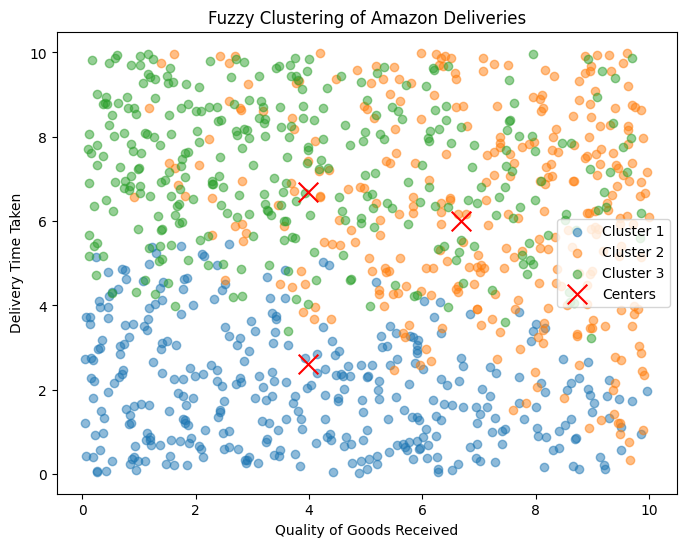

In [10]:
# Visualize the clustering result
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data points and color them by their most likely cluster
for j in range(n_clusters):
    # Select data points where cluster membership is the highest for this cluster
    cluster_membership = np.argmax(u, axis=0) == j
    ax.scatter(delivery_data[cluster_membership, 0], delivery_data[cluster_membership, 1],
               label=f'Cluster {j+1}', alpha=0.5)

# Plot cluster centers
ax.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='r', label='Centers')

ax.set_xlabel('Quality of Goods Received')
ax.set_ylabel('Delivery Time Taken')
ax.set_title('Fuzzy Clustering of Amazon Deliveries')
ax.legend()
plt.show()

#### 3.3. Interpretation of Clusters

	•	Cluster 1: Could represent “fast and high-quality deliveries with minimal damage”.
	•	Cluster 2: Might represent “late deliveries with some minor damage”.
	•	Cluster 3: Could be “damaged and low-quality goods with delayed delivery”.
